In [76]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import gc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score, roc_curve,auc, \
          confusion_matrix,precision_recall_curve,precision_recall_curve,plot_precision_recall_curve

import warnings
warnings.simplefilter('ignore')

In [77]:
train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test.csv")

In [79]:
train_data['is_train'] = True
test_data['is_train'] = False
df = pd.concat([train_data, test_data])

In [80]:
def fill_missing_vals(df, fill_missing):
    for col in fill_missing:
        df[col].fillna(df[col].median(skipna=True), inplace=True)
    return df

fill_missing = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
fill_missing_vals(df, fill_missing)
df['HomePlanet'].fillna('Z', inplace=True)

In [81]:
label_encode = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
for col in label_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [82]:
mask = df['is_train'] == True
train_data = df[mask]
test_data = df[~mask]

train_data = train_data.drop(['is_train'], axis=1)
test_data = test_data.drop(['is_train'], axis=1)

In [83]:
train_data = train_data.dropna()
train_data.drop(["PassengerId", "Cabin", "Name"], axis=1, inplace=True)
test_data.drop(["PassengerId", "Cabin", "Name"], axis=1, inplace=True)
train_data['Transported'] = train_data['Transported'].map({True:1, False:0})

In [125]:
class Config:
    lr = 1e-3
    nb_epochs = 20
    k_folds = 5
    device = 'cpu'
    train_loss_fn = nn.BCEWithLogitsLoss()
    valid_loss_fn = nn.BCEWithLogitsLoss()
    feature_names = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    target_name = 'Transported'

In [117]:
class SpaceTitanicModel(nn.Module):
    def __init__(self, input_shape=None, output_shape=None):
        super().__init__()
        self.input_shape = 10 if not input_shape else input_shape
        self.output_shape = 1 if not output_shape else output_shape
        
        self.l1 = nn.Linear(self.input_shape, 32)
        self.r1 = nn.ReLU()
        self.l2 = nn.Linear(32, self.output_shape)
#         self.r2 = nn.ReLU()
#         self.l3 = nn.Linear(128, 64)
#         self.r3 = nn.ReLU()
#         self.l4 = nn.Linear(64, self.output_shape)
        self.sig = nn.Sigmoid()
#         self.layers = [self.l1, self.r1, self.l2, self.r2, self.l3, self.r3, self.l4, self.sig]
        self.layers = [self.l1, self.r1, self.l2, self.sig]
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x        
        

In [118]:
def binary_acc(y_pred, y_test):
    y_pred = torch.round(y_pred)
    correct_results_sum = (y_pred == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [119]:
class SpaceTitanicData(Dataset):
    def __init__(self, features, target, is_test=False):
        self.features = features
        self.target = target
        self.is_test = is_test
    
    def __getitem__(self, idx):
        data = self.features.values[idx]
        if self.is_test:
            return torch.tensor(data, dtype=torch.float32)
        else:
            target = self.target.values[idx]
            return torch.tensor(data, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features)

In [126]:
def train_fn(model, train_loader, optimizer, loss_fn, device):
    print("Trainning")
    model.train()
    running_loss = 0
#     all_targets = []
#     all_preds = []
    
    prog_bar = tqdm(train_loader, total=len(train_loader))
    for X, y in prog_bar:
        X = X.to(device, torch.float32)
        y = y.to(device, torch.float32)
        
        z = model(X)
        train_loss = loss_fn(z, y)
        acc = binary_acc(z, y)
        train_loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += train_loss
        prog_bar.set_description(f"train loss: %.2f" % train_loss.item())
        
#         all_targets.append(y.detach().cpu().numpy())
#         all_preds.append(z.detach().cpu().numpy())
    
    return running_loss.item() / len(train_dataset)

In [121]:
def valid_fn(model, valid_loader, loss_fn, device):
    print("Validating")
    model.eval()
    running_loss = 0
#     all_targets = []
#     all_preds = []
    
    prog_bar = tqdm(valid_loader, total=len(valid_loader))
    for X, y in prog_bar:
        X = X.to(device, torch.float32)
        y = y.to(device, torch.float32)
        
        z = model(X)
        valid_loss = loss_fn(z, y)
        acc = binary_acc(z, y)
    
        running_loss += valid_loss
        prog_bar.set_description("valid loss: %.2f" % valid_loss.item())
        
#         all_targets.append(y.detach().cpu().numpy())
#         all_preds.append(z.detach().cpu().numpy())
    
    print("Total Validation Loss: %.2f" % (running_loss.item() / len(valid_dataset)))
    print("Acc: %.2f" % acc)
    return running_loss.item() / len(valid_dataset), acc

In [ ]:
# 将train data打乱
data = train_data.sample(frac=1).reset_index(drop=True)

kfold = StratifiedKFold(n_splits=Config.k_folds, shuffle=True)
for fold, (train_ids, valid_ids) in \
            enumerate(kfold.split(data.drop(['Transported'], axis=1), data[['Transported']])):
    print(f"fold {fold}")
    print('-'*20)
    
    # 先只测试fold=0的收敛性
    if fold == 0:
        total_train_loss = []
        total_val_loss = []
        total_val_acc = []
        train_ = data.loc[train_ids] 
        valid_ = data.loc[valid_ids]

        train_dataset = SpaceTitanicData(train_.drop(['Transported'], axis=1), train_[['Transported']])
        valid_dataset = SpaceTitanicData(valid_.drop(['Transported'], axis=1), valid_[['Transported']])

        train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

        model = SpaceTitanicModel()
        model.to(Config.device)

        optimizer = torch.optim.SGD(model.parameters(), lr=Config.lr)

        print("[INFO]: Starting training!\n")
        for epoch in range(1, Config.nb_epochs+2):
            print(f"{'='*20} Epoch {epoch} / {Config.nb_epochs+1} {'='*20}")
            train_loss = train_fn(model, train_dataloader, optimizer, Config.train_loss_fn, Config.device)
            val_loss, val_acc = valid_fn(model, valid_dataloader, Config.valid_loss_fn, Config.device)
            total_train_loss.append(train_loss)
            total_val_loss.append(val_loss)
            total_val_acc.append(val_acc)
    else:
        break
    
#     torch.save(model.state_dict(), f"fold_{fold}_model.pth")

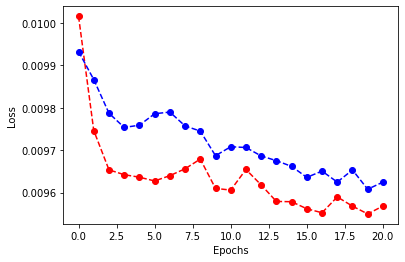

In [128]:
import matplotlib.pyplot as plt

plt.plot(range(Config.nb_epochs+1), total_train_loss, 'ro--', label='train loss')
plt.plot(range(Config.nb_epochs+1), total_val_loss, 'bo--', label='val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


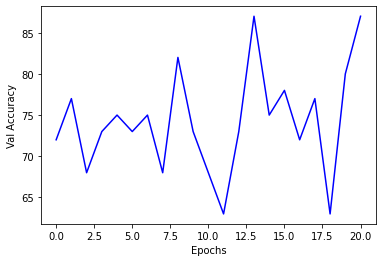

In [129]:
plt.plot(range(Config.nb_epochs+1), total_val_acc, 'b-', label='val acc')
plt.xlabel("Epochs")
plt.ylabel("Val Accuracy")
plt.show()

In [59]:
@torch.no_grad()
def inference(model, state_lists, test_dataloader, device):
    model.eval()
    all_preds = []
    for state in state_lists:
        print(f"State: {state}")
        state_dict = torch.load(state)
        model.load_state_dict(state_dict)
        model = model.to(device)
        
        del state_dict
        gc.collect()
        
        preds = []
        prog = tqdm(test_dataloader, total=len(test_dataloader))
        for X in prog:
            X = X.to(device)
            outputs = model(X)
            # squeeze(-1)应该是压缩维度
            preds.append(outputs.squeeze(-1).cpu().detach().numpy())
        
        all_preds.append(np.concatenate(preds))
        
        gc.collect()
        torch.cuda.empty_cache()
        
    return all_preds

In [60]:
state_lists = [os.path.join("./models", x) for x in os.listdir("./models") if x.endswith(".pth")]

test_dataset = SpaceTitanicData(features=test_data.drop(['Transported'], axis=1), target=None, is_test=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Prediction for all folds")
predictions = inference(model, state_lists, test_dataloader, Config.device)

Prediction for all folds
State: ./models/fold_0_model.pth


  0%|          | 0/134 [00:00<?, ?it/s]

State: ./models/fold_1_model.pth


  0%|          | 0/134 [00:00<?, ?it/s]

State: ./models/fold_2_model.pth


  0%|          | 0/134 [00:00<?, ?it/s]

State: ./models/fold_4_model.pth


  0%|          | 0/134 [00:00<?, ?it/s]

State: ./models/fold_3_model.pth


  0%|          | 0/134 [00:00<?, ?it/s]

In [65]:
preds = pd.DataFrame(predictions).T.mean(axis=1).tolist()
preds = torch.round(torch.FloatTensor(preds)).numpy() > 0
preds

array([ True, False,  True, ...,  True, False,  True])

In [72]:
passenger_IDs = pd.read_csv("../input/sample_submission.csv")["PassengerId"].values

In [74]:
df = {'PassengerId': passenger_IDs, 'Transported': preds}
df_preds = pd.DataFrame(df).set_index(['PassengerId'])
df_preds.head()

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,False
0023_01,False


In [75]:
df_preds.to_csv('../output/pytorch_predction.csv')